## Import libraries

In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Read dataset

In [16]:
pisa = pd.read_csv('pisa2009.csv')


## Preprocess

In [17]:
# Handle Missing values
# For continuous variables replace the missing data with average of columns
pisa['minutesPerWeekEnglish'].fillna(int(pisa['minutesPerWeekEnglish'].mean()), inplace=True)
pisa['studentsInEnglish'].fillna(int(pisa['studentsInEnglish'].mean()), inplace=True)
pisa['schoolSize'].fillna(int(pisa['schoolSize'].mean()), inplace=True)

# For 'raceeth' use 'missing' replacement
pisa['raceeth'].fillna('NoRace', inplace=True)
# For binary variable use 0.5 in place of missing value

pisa = pisa.apply(lambda x:x.fillna(0.5))

# Encode categorical data
raceeth = pd.get_dummies(pisa['raceeth'], 'raceeth')
pisa = pd.concat([pisa, raceeth], axis=1)
pisa = pisa.drop('raceeth', axis=1)

# remove multicolinearity
pisa = pisa.drop(['motherBachelors','motherBornUS', 'fatherBornUS'], axis=1)

X = pisa.drop('readingScore', axis=1).values
y = pisa['readingScore']

In [36]:
X = pisa[['expectBachelors','schoolSize', 'minutesPerWeekEnglish', 'studentsInEnglish', 'grade']]
X.shape

(5233, 5)

## Train Test split

In [37]:
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Benchmark

In [38]:
# Use average of scores as benchmark
benchmark_train_pred = np.empty(y_train.shape[0])
benchmark_train_pred.fill(np.mean(y_train))

benchmark_train_rmse = np.sqrt(mean_squared_error(y_train, benchmark_train_pred))
benchmark_train_r2 = r2_score(y_train, benchmark_train_pred)
print 'Benchmark rmse on training set:', benchmark_train_rmse
print 'Benchmark r2 on training set:', benchmark_train_r2

benchmark_test_pred = np.empty(y_test.shape[0])
benchmark_test_pred.fill(np.mean(y_test))

benchmark_test_rmse = np.sqrt(mean_squared_error(y_test, benchmark_test_pred))
benchmark_test_r2 = r2_score(y_test, benchmark_test_pred)
print 'Benchmark rmse on test set:', benchmark_test_rmse
print 'Benchmark r2 on test set:', benchmark_test_r2

Benchmark rmse on training set: 95.8746849473
Benchmark r2 on training set: 0.0
Benchmark rmse on test set: 94.4118356767
Benchmark r2 on test set: 0.0


## Model with default parameters

In [40]:
model = GradientBoostingRegressor()
kfold = KFold(n_splits=10, random_state=7)
cv_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error'))
cv_r2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
print("RMSE: %f (%f) r2: %f (%f)" % ( cv_rmse.mean(), cv_rmse.std(), cv_r2.mean(), cv_r2.std()))

RMSE: 80.589360 (2.579401) r2: 0.289374 (0.049247)


## Tuning max_depth

In [22]:
from sklearn.model_selection import GridSearchCV
# Tune  GBM

max_depth = range(1, 11)
param_grid = dict(max_depth=max_depth)

model = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=10, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=kfold)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.396097 using {'max_depth': 4}
0.350008 (0.024771) with: {'max_depth': 1}
0.383342 (0.031714) with: {'max_depth': 2}
0.395863 (0.037489) with: {'max_depth': 3}
0.396097 (0.041184) with: {'max_depth': 4}
0.388151 (0.046541) with: {'max_depth': 5}
0.380201 (0.049167) with: {'max_depth': 6}
0.358921 (0.045949) with: {'max_depth': 7}
0.337311 (0.054641) with: {'max_depth': 8}
0.304730 (0.057597) with: {'max_depth': 9}
0.272152 (0.067554) with: {'max_depth': 10}


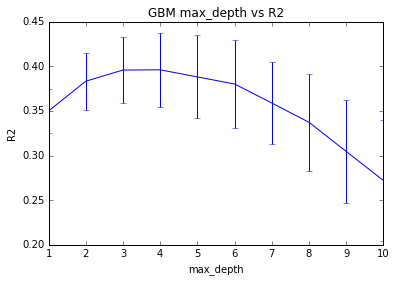

In [25]:
plt.errorbar(max_depth, means, yerr=stds)
plt.title("GBM max_depth vs R2")
plt.xlabel('max_depth')
plt.ylabel('R2')

## Tuning n_estimators

In [34]:
max_depth = 4
n_estimators = range(50, 600, 50)
param_grid = dict(n_estimators=n_estimators)

model = GradientBoostingRegressor(max_depth= max_depth, random_state=seed)
kfold = KFold(n_splits=10, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=kfold)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.397017 using {'n_estimators': 150}
0.382914 (0.034040) with: {'n_estimators': 50}
0.396097 (0.041184) with: {'n_estimators': 100}
0.397017 (0.041212) with: {'n_estimators': 150}
0.393913 (0.042431) with: {'n_estimators': 200}
0.390130 (0.044083) with: {'n_estimators': 250}
0.385075 (0.045792) with: {'n_estimators': 300}
0.380137 (0.046892) with: {'n_estimators': 350}
0.376094 (0.046991) with: {'n_estimators': 400}
0.371601 (0.048583) with: {'n_estimators': 450}
0.368139 (0.049196) with: {'n_estimators': 500}
0.363062 (0.049780) with: {'n_estimators': 550}


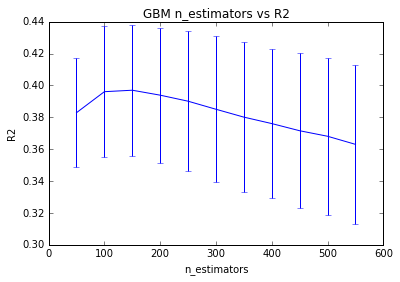

In [28]:
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("GBM n_estimators vs R2")
plt.xlabel('n_estimators')
plt.ylabel('R2')

## Tuning loss

In [29]:
max_depth = 4
n_estimators = 150
loss =['ls', 'lad','huber','quantile']

param_grid = dict(loss=loss)

model = GradientBoostingRegressor(max_depth= max_depth, random_state=seed)
kfold = KFold(n_splits=10, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=kfold)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.396097 using {'loss': 'ls'}
0.396097 (0.041184) with: {'loss': 'ls'}
0.396052 (0.036434) with: {'loss': 'lad'}
0.395521 (0.037696) with: {'loss': 'huber'}
-0.591284 (0.114796) with: {'loss': 'quantile'}


## Finalize Model

In [32]:
model = GradientBoostingRegressor(max_depth= max_depth, random_state=seed)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, predictions))
test_r2 = r2_score(y_test, predictions)
print('test set rmse: %.2f is better compared to baseline %.2f' % (test_rmse, benchmark_test_rmse))
print('test set r2: %.2f is better than baseline %.2f' % (test_r2, benchmark_test_r2))

test set rmse: 72.35 is better compared to baseline 94.41
test set r2: 0.41 is better than baseline 0.00
